#               Проект на тему "Прогнозирование заказов такси"

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Вам нужно:

Загрузить данные и выполнить их ресемплирование по одному часу.
Проанализировать данные.
Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
Проверить данные на тестовой выборке и сделать выводы.
Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).

#                                                 Содержание 

# 1. Загрузка и подготовка данных
### 1.1. Загрузка и установка необходимых библиотек
### 1.2. Импорт необходимых библиотек
### 1.3. Загрузка данных
### 1.4. Ресэмплирование
### 1.5. Проверка на стационарность

# 2. Анализ данных
### 2.1. Декомпозиция временного ряда
### 2.2. Анализ тренда
### 2.3 Анализ сезонности
### 2.4. Анализ остатков

# 3. Обучение моделей
### 3.1. Создание функции генерации дополнительных признаков для временных рядов
### 3.2. Обучение и кросс-валидация модели линейной регрессии
### 3.3. Обучение и кросс-валидация модели случайного леса
### 3.4. Обучение и кросс-валидация CatBoost
### 3.5. Выбор лучшей модели на основе кросс-валидации

# 4. Проверка на тестовой выборке

# 5. Вывод

# 1. Загрузка и подготовка данных

## 1.1. Загрузка и установка необходимых библиотек

In [4]:
!pip install tune_sklearn --user

  Using cached tune_sklearn-0.4.6-py3-none-any.whl (41 kB)
  Using cached ray-2.6.1-cp310-cp310-win_amd64.whl (22.3 MB)
  Using cached protobuf-4.23.4-cp310-abi3-win_amd64.whl (422 kB)
  Using cached grpcio-1.56.2-cp310-cp310-win_amd64.whl (4.2 MB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached frozenlist-1.4.0-cp310-cp310-win_amd64.whl (44 kB)
  Using cached tensorboardX-2.6.1-py2.py3-none-any.whl (101 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
!pip install catboost

## 1.2. Импорт необходимых библиотек

In [9]:
#основное
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#разное
plt.style.use('dark_background')
import warnings
warnings.filterwarnings("ignore")


#модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
#from tune_sklearn import TuneGridSearchCV
from catboost import CatBoostRegressor
from catboost import cv, Pool

#обучение
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score

#метрики
from sklearn.metrics import make_scorer, mean_squared_error
from math import sqrt

#разное
plt.style.use('dark_background')
import warnings
warnings.filterwarnings("ignore")

## 1.3. Загрузка данных

Загрузим таблицу и сразу приведем формат даты в datetime64 и сделаем этот столбец индексами.

In [5]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0],index_col=[0])

Просмотр таблицы

In [6]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## 1.4. Ресэмплирование

Проверим дату на расположение в хронологическом порядке.

In [7]:
df.index.is_monotonic

C:\Users\Aleksey\AppData\Local\Temp\ipykernel_17872\2090065119.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df.index.is_monotonic


True

Дата располагается в хронологическом порядке. Можно провести ресэмплинг. Будем ресэмплировать по 1 дню и находить суммарное количество заказов за этот период.

<Axes: xlabel='datetime'>

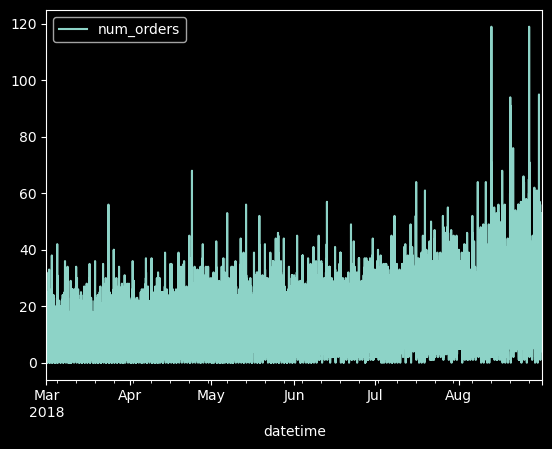

In [10]:
df.plot()

Видно, что общий тренд идет на увеличение заказов.

In [11]:
df_resample = df.resample('1H').sum()

In [12]:
df_resample

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [ ]:
from statsmodels.tsa.stattools import adfuller 
# тест Дики-Фуллера - проверка ряда на стационарность

In [ ]:
# функция проверка ряда
def adf_test(timeseries):
    # Выполняем тест Дики-Фуллера:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
adf_test(train['num_orders'])

Results of Dickey-Fuller Test:
Test Statistic                -1.254889e+01
p-value                        2.228638e-23
#Lags Used                     4.800000e+01
Number of Observations Used    2.644700e+04
Critical Value (1%)           -3.430597e+00
Critical Value (5%)           -2.861649e+00
Critical Value (10%)          -2.566828e+00
dtype: float64

Интерпритация значений: Результаты теста Dickey-Fuller указывают на то, что у нас есть достаточно сильное доказательство против гипотезы о наличии единичного корня в рассматриваемом временном ряду.

Test Statistic (-1.254889e+01) меньше всех критических значений (Critical Value), что означает, что мы можем отклонить нулевую гипотезу о наличии единичного корня. Это указывает на стационарность ряда.

P-value (2.228638e-23) очень маленькое, что также подтверждает отклонение нулевой гипотезы. Обычно принимается уровень значимости 0.05, поэтому при таком уровне значимости мы бы отклонили нулевую гипотезу.

Количество использованных лагов (#Lags Used) составляет 48, а количество использованных наблюдений (Number of Observations Used) равно 26,447. Это информация о том, сколько лагов и наблюдений было учтено при проведении теста.

В целом, основываясь на результатах теста Dickey-Fuller, можно сделать вывод, что рассматриваемый временной ряд является стационарным.

KPSS - это еще один тест для проверки стационарности временного ряда (чуть менее популярный, чем тест Дики Фуллера). Нулевая и альтернативная гипотеза для теста KPSS противоположны гипотезе ADF, что часто создает путаницу.

Авторы теста KPSS определили в нулевой гипотезе, что процесс является стационарным тренда. Мы разберем стационарность тренда подробно в следующем разделе. А пока давайте сосредоточимся на реализации и посмотрим результаты теста KPSS.

Нулевая гипотеза: стационарный процесс тренда.

Альтернативная гипотеза: ряд имеет единичный корень (ряд не является стационарным).

KPSS - это еще один тест для проверки стационарности временного ряда (чуть менее популярный, чем тест Дики Фуллера). Нулевая и альтернативная гипотеза для теста KPSS противоположны гипотезе ADF, что часто создает путаницу.

Авторы теста KPSS определили в нулевой гипотезе, что процесс является стационарным тренда. Мы разберем стационарность тренда подробно в следующем разделе. А пока давайте сосредоточимся на реализации и посмотрим результаты теста KPSS.

Нулевая гипотеза: стационарный процесс тренда.

Альтернативная гипотеза: ряд имеет единичный корень (ряд не является стационарным).

In [ ]:
# определяем функцию для теста kpss
from statsmodels.tsa.stattools import kpss

In [ ]:
# определяем KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [ ]:
kpss_test(train['num_orders'])

Results of KPSS Test:
Test Statistic           21.761984
p-value                   0.010000
Lags Used                85.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Тест на стационарность: если статистика теста больше критического значения, мы отвергаем нулевую гипотезу (ряд не является стационарным). Если статистика теста меньше критического значения, не удастся отклонить нулевую гипотезу (ряд является стационарным).

# 2. Анализ данных

### 2.1. Декомпозиция временного ряда

<Axes: xlabel='datetime'>

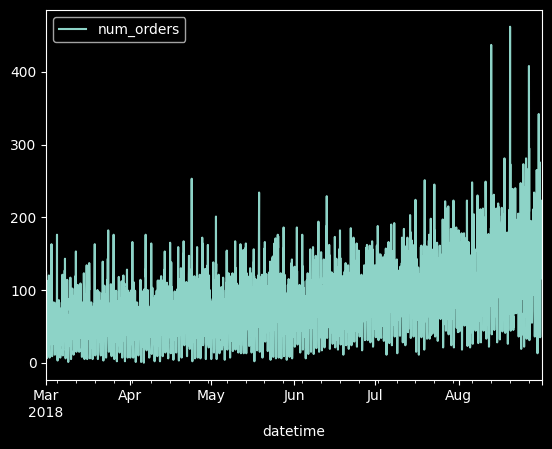

In [10]:
df_resample.plot()

Видно, что примерно с середины августа в некоторые дни наблюдается больше количество заказов, чем раньше.

In [11]:
decomposed = seasonal_decompose(df_resample)

### 2.2. Анализ тренда

Text(0.5, 1.0, 'Trend')

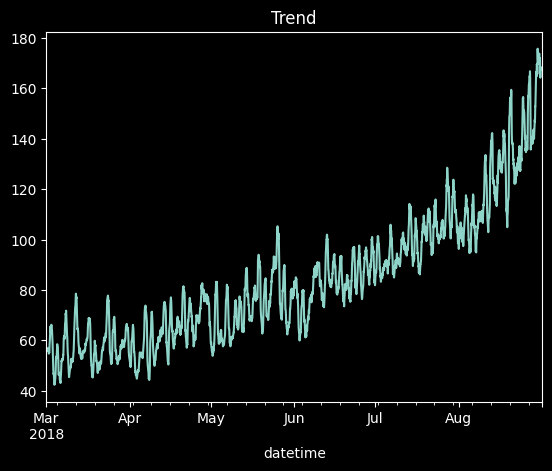

In [12]:
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

Видно, что общий тренд количества заказов идет на увеличение.

### 2.3 Анализ сезонности

Text(0.5, 1.0, 'Seasonality')

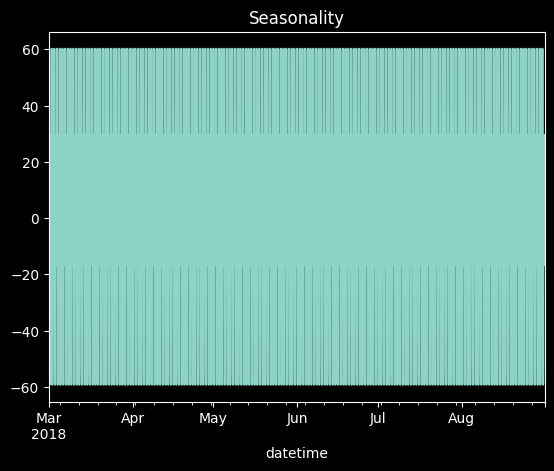

In [13]:
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Все слишком плотно. Сделаем более мелкий ресэмплинг.

In [14]:
df_hour = df['2018-03-01 00:00:00':'2018-03-03 00:00:00'].resample('1H').sum()

In [15]:
decomposed_hour = seasonal_decompose(df_hour)

Text(0.5, 1.0, 'Seasonality in hour')

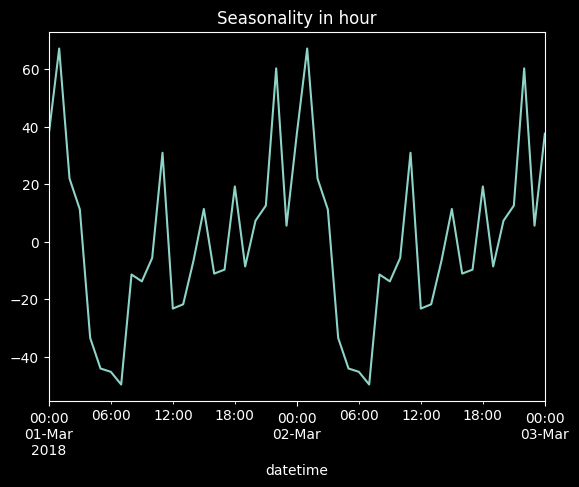

In [16]:
decomposed_hour.seasonal.plot(ax=plt.gca())
plt.title('Seasonality in hour')

Видно, что в течение дня количество заказов сильно различается - есть несколько пиков. Основные - это обеденный и вечерний.

### 2.4. Анализ остатков

Text(0.5, 1.0, 'Residuals')

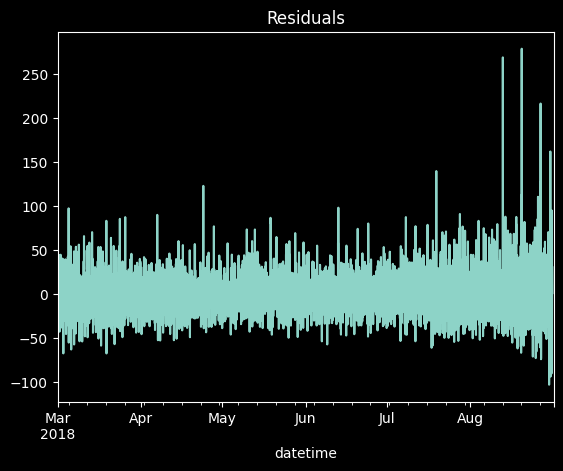

In [ ]:
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

Видно, что начиная с августа величина остатков, не укладывающихся в тренд значительно увеличивается. Это может говорить о том, что общий тренд изменился. Например, увеличился градиент. Проверим это при ресэмплировании по одному дню.

In [17]:
df_day = df.resample('1D').sum()

In [18]:
decomposed_day = seasonal_decompose(df_day)

Text(0.5, 1.0, 'Trend in day')

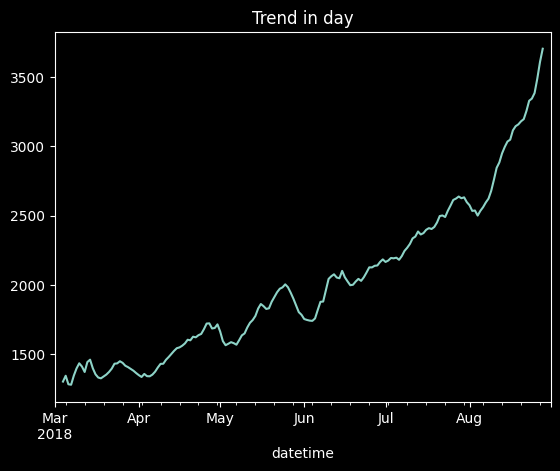

In [19]:
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend in day')

На последнем графике видно, что линейная зависимость закачивается в начале августа. Дальше идет всплеск заказов.

# 3. Обучение моделей

### 3.1. Создание функции генерации дополнительных признаков для временных рядов

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    column = data.columns[0]
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

    return data




### 3.2. Обучение и кросс-валидация модели линейной регрессии

Для обучения моделей сделаем цикл, который будет перебирать количество сдвигов. Количество признаков соответственно также будет изменяться.

 Поскольку в данном проекте мы имеем дело с временными рядами обычная кросс-валидация здесь не применима. Используем TimeSeriesSplit - метод разделения временных рядов на обучающие и тестовые подвыборки в машинном обучении. Он представляет собой специальный тип кросс-валидации, который учитывает порядок данных во времени.

In [148]:
LG = [] # список для лучших значений RMSE на кросс-валидации


best_model_lg_all = None  # для лучшей модели

best_score_lg_ = 100000 # для определения лучшей модели

for i in range(1,60,10):

  df_resample = df.resample('1H').sum() # обновляем данные

  make_features(df_resample, i, i)   # создание новых столбцов признаков


  df_resample.dropna(inplace = True)  # удаление пропусков

  train, test = train_test_split(df_resample, shuffle=False, test_size=0.1) #разделение на обучающую и тестовую

  # разделение на признаки и целевую переменную
  X_train = train.drop(['num_orders'],axis=1)
  y_train = train['num_orders']
  X_test = test.drop(['num_orders'],axis=1)
  y_test = test['num_orders']

  # Создаем объект TimeSeriesSplit с заданием количества фолдов (n_splits)
  tscv = TimeSeriesSplit(n_splits=3)

  param_grid_lg = {
    'fit_intercept': [True, False],
    'positive': [True, False],
}

 # Создаем модель
  model_lg = LinearRegression()

# Создаем объект TuneGridSearchCV для поиска по сетке с кросс-валидацией
  grid_search_lg = TuneGridSearchCV(estimator=model_lg, param_grid=param_grid_lg, cv=tscv,
                                    scoring=make_scorer(mean_squared_error))

# Обучение модели с поиском по сетке и кросс-валидацией
  grid_search_lg.fit(X_train, y_train)

# Лучшие параметры и лучшая оценка модели
  best_params_lg = grid_search_lg.best_params_

  best_score_lg = grid_search_lg.best_score_

  best_model_lg = grid_search_lg.best_estimator_

# Нахождение лучшей модели
  if best_score_lg <  best_score_lg_:
    best_score_lg_ = best_score_lg
    best_model_lg_all = best_model_lg
    X_test_best = X_test

  LG.append(round(np.sqrt(best_score_lg), 2))




2023-07-28 18:08:28,704	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-------------------------------------------------------------------+
| Configuration for experiment     _Trainable_2023-07-28_18-08-28   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 4                                |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/_Trainable_2023-07-28_18-08-28
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_Trainable_2023-07-28_18-08-28`



2023-07-28 18:08:35,516	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-------------------------------------------------------------------+
| Configuration for experiment     _Trainable_2023-07-28_18-08-35   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 4                                |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/_Trainable_2023-07-28_18-08-35
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_Trainable_2023-07-28_18-08-35`



2023-07-28 18:08:45,164	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-------------------------------------------------------------------+
| Configuration for experiment     _Trainable_2023-07-28_18-08-45   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 4                                |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/_Trainable_2023-07-28_18-08-45
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_Trainable_2023-07-28_18-08-45`



2023-07-28 18:08:52,393	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-------------------------------------------------------------------+
| Configuration for experiment     _Trainable_2023-07-28_18-08-52   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 4                                |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/_Trainable_2023-07-28_18-08-52
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_Trainable_2023-07-28_18-08-52`



2023-07-28 18:09:02,664	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-------------------------------------------------------------------+
| Configuration for experiment     _Trainable_2023-07-28_18-09-02   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 4                                |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/_Trainable_2023-07-28_18-09-02
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_Trainable_2023-07-28_18-09-02`



2023-07-28 18:09:09,220	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-------------------------------------------------------------------+
| Configuration for experiment     _Trainable_2023-07-28_18-09-09   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 4                                |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/_Trainable_2023-07-28_18-09-09
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_Trainable_2023-07-28_18-09-09`



In [146]:
LG

[32.68, 32.65, 32.67, 27.94, 27.93, 25.9]

In [150]:
round(np.sqrt(best_score_lg_),2)

25.9

Общая закономерность очевидна - с увеличением количества сдвигов метрика становится лучше. Для остальных моделей будем брать max_lag, rolling_mean_size равными 50.

### 3.3. Обучение и кросс-валидация модели случайного леса

In [152]:
make_features(df_resample, 50, 50)   # создание новых столбцов признаков


df_resample.dropna(inplace = True)  #удаление пропусков

In [155]:
train, test = train_test_split(df_resample, shuffle=False, test_size=0.1) #разделение на обучающую и тестовую

In [156]:
  # разделение на признаки и целевую переменную
  X_train = train.drop(['num_orders'],axis=1)
  y_train = train['num_orders']
  X_test = test.drop(['num_orders'],axis=1)
  y_test = test['num_orders']

In [157]:
param_grid_rf = {
  'n_estimators': [100, 200, 500],  # Количество деревьев в лесу
  'max_depth': [5, 10, 20],       # Максимальная глубина деревьев
  'min_samples_split': [2, 4, 8]   # Минимальное количество образцов для разделения узла
}

# Создаем модель случайного леса
model_rf = RandomForestRegressor()

# Создаем объект GridSearchCV для поиска по сетке с кросс-валидацией
grid_search_rf = TuneGridSearchCV(estimator=model_rf, param_grid = param_grid_rf, cv=tscv,
                              scoring=make_scorer(mean_squared_error, squared=False))

# Обучение модели с поиском по сетке и кросс-валидацией
grid_search_rf.fit(X_train, y_train)

# Лучшие параметры и лучшая оценка модели
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
print("Best Parameters:", best_params_rf)
print("Best Score:", round(best_score_rf, 4))

2023-07-28 18:18:32,554	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-------------------------------------------------------------------+
| Configuration for experiment     _Trainable_2023-07-28_18-18-32   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 27                               |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/_Trainable_2023-07-28_18-18-32
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_Trainable_2023-07-28_18-18-32`

Best Parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 4}
Best Score: 27.3843


### 3.4. Обучение и кросс-валидация CatBoost

In [14]:
make_features(df_resample, 50, 50)   # создание новых столбцов признаков


df_resample.dropna(inplace = True)

In [15]:
train, test = train_test_split(df_resample, shuffle=False, test_size=0.1) #разделение на обучающую и тестовую

In [16]:
  # разделение на признаки и целевую переменную
  X_train = train.drop(['num_orders'],axis=1)
  y_train = train['num_orders']
  X_test = test.drop(['num_orders'],axis=1)
  y_test = test['num_orders']

In [17]:
train_data = Pool(data=X_train,
                  label=y_train
                                   )


# Указываем параметры модели
params = {'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
              'learning_rate': 0.05,
              'random_seed': 2007,
              'verbose':100}


# Проводим кросс-валидацию

cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=3,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False,
    early_stopping_rounds=200
)



# Создаем модель CatBoostRegressor
model_cb = CatBoostRegressor(**params)

# Обучаем модель CatBoostRegressor
model_cb.fit(train_data)

Training on fold [0/3]

bestTest = 21.60939549
bestIteration = 987

Training on fold [1/3]

bestTest = 21.47380031
bestIteration = 999

Training on fold [2/3]

bestTest = 22.55971879
bestIteration = 996

0:	learn: 37.7402763	total: 6.51ms	remaining: 6.51s
100:	learn: 21.4611294	total: 557ms	remaining: 4.96s
200:	learn: 19.2889349	total: 1.1s	remaining: 4.39s
300:	learn: 17.2787216	total: 1.65s	remaining: 3.83s
400:	learn: 15.8373719	total: 2.19s	remaining: 3.27s
500:	learn: 14.5078537	total: 2.73s	remaining: 2.72s
600:	learn: 13.3889363	total: 3.28s	remaining: 2.18s
700:	learn: 12.3564525	total: 3.83s	remaining: 1.63s
800:	learn: 11.5476949	total: 4.38s	remaining: 1.09s
900:	learn: 10.7819291	total: 4.94s	remaining: 543ms
999:	learn: 10.0202316	total: 5.49s	remaining: 0us


In [18]:
best_score_CB = cv_data['test-RMSE-mean'].min()

### 3.5. Выбор лучшей модели на основе кросс-валидации

In [169]:
data = {'Linear_Regression': [round(np.sqrt(best_score_lg_), 2)],
        'RandomForest': [round(best_score_rf, 2)],
        'CatBoost': [best_score_CB]}

# Создание датафрейма
df_ = pd.DataFrame(data)

In [170]:
df_

,Linear_Regression,RandomForest,CatBoost
0,25.9,27.38,22.03301


Лучший результат на кросс-валидации показал CatBoost. Возьмем его для проверки на тестовой выборке.

# 4. Проверка на тестовой выборке

In [19]:
test_data = Pool(data=X_test,
                  label=y_test
                                   )

y_pred_cb = model_cb.predict(test_data)

# Оценка качества модели
mse_cb = mean_squared_error(y_test, y_pred_cb)
print('Root Mean Squared Error:', round(np.sqrt(mse_cb)))

Root Mean Squared Error: 39


Результат на тестовой выборке укладывается в необходимые RMSE < 48

Построим график с реальным и предсказанным значением тестовой выборки.

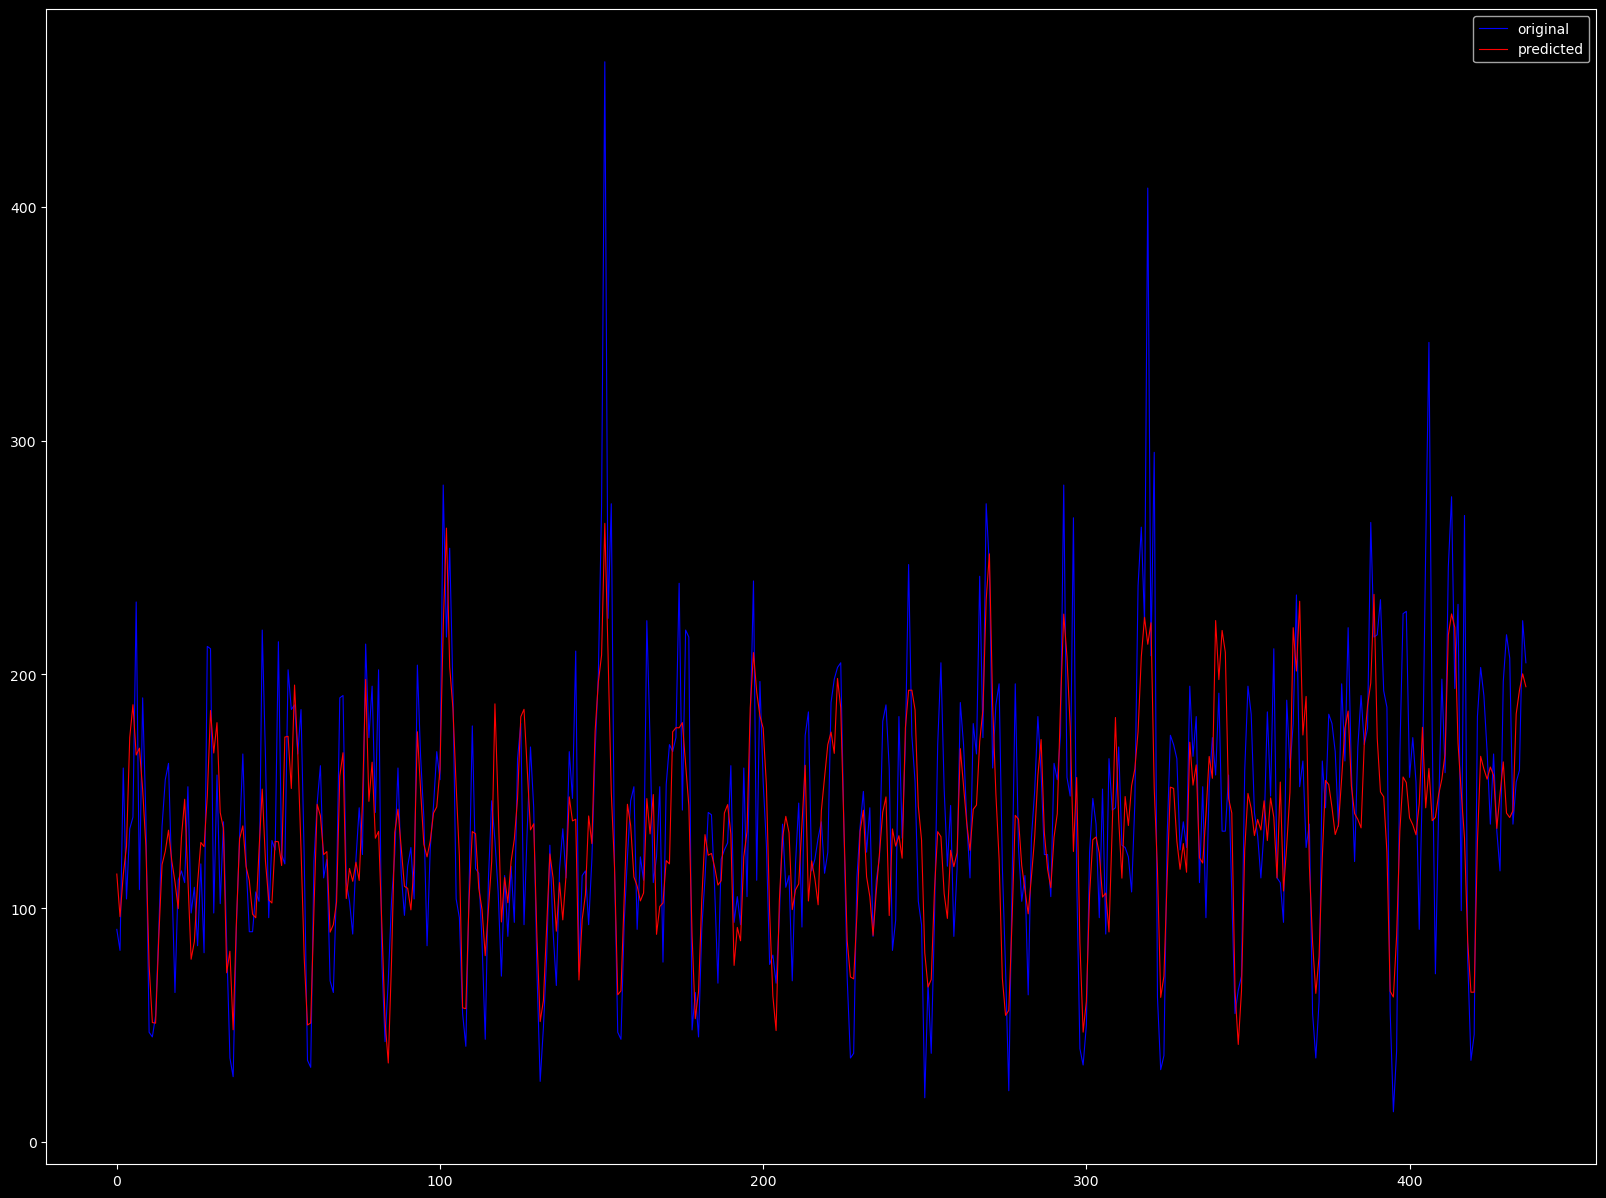

In [20]:
x_ax = range(len(X_test))
plt.figure(figsize=(20, 15))
plt.plot(x_ax, y_test, lw=0.8, color="blue", label="original")
plt.plot(x_ax, y_pred_cb, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

В общем модель справляется с предсказанием. Однако она учитывает не все всплески.

# 5. Вывод

В соответствии с проведенным анализом предоставленных данных значительный рост заказов приходится как раз на тестовую выборку.

Рост начинается в начале августа, который выбивается из общего предшествующего тренда.
Соответственно модель, обученная на относительно линейном участке и захватывающая малую часть нелинейного периода плохо справляется с предсказанием на тестовых данных. Если брать количество сдвигов небольшим, то метрика получается слишком высокой.

При значении количества сдвигов равным 50 метрика и на кросс-валидации и на тестовой выборке достигает необходимого значения.